# Distributed GPU Training Job for PyTorch Image Classification

The purpose of this notebook is to provide a technical documentation for a greater accelerated training process. This is done through a methodological approach known as distributed GPU training process. This involves a multi-node multi-gpu pytorch job, wherin MLFlow was used to analyze the metrics.  

**Requirements & Dependencies:**
1. Provisioned AzureML workspace with Azure subscription
2. Appropriate permissions to provision minimal CPU and GPU cluster 
3. Azure ML Python SDK V2


## Connection to AzureML Client

An instance of the MLClient was created to connect to AzureML service. The use of `DefaultAzureCredential` is used to access the workspace and resource wherin the code is located in. This service principle policy allows the user to authenticate to access the client in a secured manner. 

In [2]:
# Import the required libraries for this auth step
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

# tru catch method to retrieve this form of connection with a token
try:
    credential = DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")

# when this form of connection doesn't work, it will prompt a manual login
except Exception as error:
    credential = InteractiveBrowserCredential()


In [3]:
# Import the ml client library
from azure.ai.ml import MLClient

# Prepare the information needed to access it in the account
ml_client = MLClient(
    subscription_id="<SUBSCRIPTION_ID>",
    resource_group_name="resource1",
    workspace_name="workspace1",
    credential=credential,
)
cpu_cluster = None
gpu_cluster = None

## Creation of Clusters
There are two types of clusters on Azure that are required for this project. This includes CPU and GPU cluster. 

1. **CPU**: Consists of VMs to handle computing tasks such as running applications, handling web applications, and performing data processing. Don't rely on parallel processing. 

2. **GPU**: Consists of VMs for parallel processing and for heavy computation work such as ML, scientific simulations, video rendering, etc. Azure uses the NVIDIA Tesla series as a VM to perform deep learning tasks. VMs are software-emulation of physical computers that run on their own OS(guest OS) and runs independently of other VMs in the same host machine. The diagram below represents a view of NVIDIA Tesla GPU's architecture diagram. 

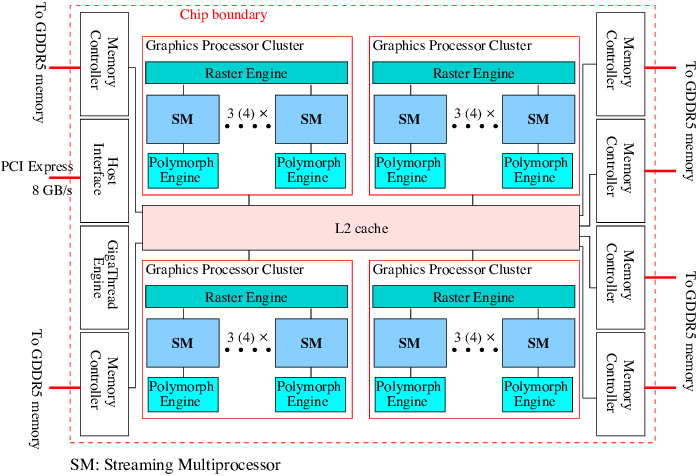


In [5]:
# Import the cpu library from Azure
from azure.ai.ml.entities import AmlCompute

cpu_compute_target = "project-cpu-cluster"

# Determine if the compute target already exists and return a message for it
try:
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(f"You already have a cluster of the same name which is {cpu_compute_target}")

# We're not catching an error, but its an exception  
except Exception:
    print("Creating a new CPU compute target...")

    # Create an Azure ML Compute Object 
    cpu_cluster = AmlCompute(
        # Name of cluster
        name = "{cpu_compute_target}",

        # Describe the VM service 
        type = "amlcompute",

        # VM Family
        size = "STANDARD_DS3_V2",

        # Min nodes 
        min_instances = 0,

        # Max nodes
        max_instances = 5,

        #Time for node to run after job has been terminated
        idle_time_before_scale_down = 200,

        # Define the cost tier - LowPriority or Dedicated. 
        tier = "Dedicated",
    )

    # Pass the object to the MLClient for creation and updation
    cpu_cluster_client = ml_client.begin_create_or_update(cpu_cluster)

# print statement in the end to show the success of creation 
print(f"The compute with the name is {cpu_cluster_client.name} is made and the size is {cpu_cluster_client.size}")

Creating a new CPU compute target...
The compute with the name is project-cpu-cluster is made and the size is STANDARD_DS3_V2


In [6]:
# Import the required libraries for AML compute
from azure.ai.ml.entities import AmlCompute

gpu_cluster_target = "project-gpu-cluster"

# check if the gpu cluster exists
try:
    gpu_cluster = ml_client.compute.get(gpu_cluster_target)
    print(f"Theres a gpu clusterwith a name {gpu_cluster_target} that already exists")


# compute using gpu compute cluster by making one
except Exception:
    print("Creating a new gpu compute target...")

    gpu_cluster = AmlCompute(
        # Name of cluster
        name = "project-gpu-cluster", 

        # Describe the VM service 
        type = "amlcompute",

        # VM Family
        size = "STANDARD_NC6s_v3",

        # Min number of nodes
        min_instances = 0,

        # Max number of nodes
        max_instances = 5,

        #Time for node to run after job has been terminated
        idle_time_before_scale_down = 200,

        # Define the cost tier
        tier = "Dedicated",

    )

    # pass the object to the ml client
    gpu_cluster_client = ml_client.begin_create_or_update(gpu_cluster)

print(f"AML Compute with the name {gpu_cluster_client.name} and the size of {gpu_cluster_client.size} ")


Creating a new gpu compute target...
AML Compute with the name project-gpu-cluster and the size of STANDARD_NC6s_v3


## Unzipping Image Archives 
To train the machine learning classifier, it is crucial to take in the dataset from local and extract the zip archive before putting them in train and validation folder. 

```
tar xvfm ${{inputs.archive}} --no-same-owner -C ${{outputs.images}}
```

Parameters like the location of archive and output directory are injected into the command using the command. This is applied further in the code itself. 

In [ ]:
# import the required libraries
from azure.ai.ml import command 
from azure.ai.ml import Input, Output
from azure.ai.ml.constants import AssetTypes 

# Command for unzipping the files in the directory
dataset_untar_command_jar = command(
    # Name for the UI (optional)
    display_name = "untarring_command",

    # apply the command
    command = "tar xvfm ${{inputs.archive}} --no-same-owner -C ${{outputs.images}}",

    # inputs
    inputs = {
        "archive": Input(
            type = AssetTypes.URI_FILE, 
            path = "https://drive.google.com/file/d/1BGnigrVXeQ-Oeh04wIyG0HcEH4_f_kgf/view?usp=sharing"
        )
    },

    # outputs 
    outputs = {
        "images": Output(
            type = AssetTypes.URI_FOLDER,
            mode = "upload",
            path="azureml://datastores/workspaceblobstore/paths/datasets",

        ),
    },

    # define the environment
    environment = "AzureML-sklearn-1.0-ubuntu20.04-py38-cpu:1",

    # define the compute (Lambda Expression in Python)
    compute = lambda client: "project-cpu-cluster" if client else None
    
)